## Linear and Multiple Regression

In [1]:
# import all necessary libraries
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn_qqplot as sqp
import seaborn as sns
import numpy as np


#regression libraries
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model


### Read/Prepare data

 - Import Data

In [2]:
f1 = []

for i, year in enumerate(list(range(2014,2019))):
    f1.append(pd.read_csv("data/%s_Data.csv"%str(year), encoding='latin-1'))
    f1[i]["year"] = year
    f1[i].columns = [x.strip() for x in f1[i].columns]

f1_df = pd.concat(f1, sort=True)
f1_df = f1_df.reset_index()

- Remove Pay drivers from our data as they do not recieve a salary for driving

In [3]:
notPayDriver = f1_df["Pay Driver?"] == 0

f1_df = f1_df[notPayDriver].copy()

- Convert Teams to Numbers

In [4]:
team_converter = {'caterham': "caterham",
                  'ferrari': "ferrari",
                  'force india': 'force india',
                  'lotus': 'lotus',
                  'marussia': 'marussia',
                  'mclaren': 'mclaren',
                  'mercedes': 'mercedes',
                  'red bull': 'red bull',
                  'sauber': 'sauber',
                  'toro rosso': 'toro rosso',
                  'williams': 'williams',
                  'manor': 'manor',
                  'mercerdes': 'mercedes',
                  'hass': 'haas',
                  'red bull/toro rosso': 'red bull/toro rosso',
                  'renault': 'renault',
                  'red bull racing': 'red bull',
                  'mclaren f1 team': 'mclaren',
                  'renault f1 team': 'renault',
                  'haas': 'haas'}

f1_df["Team"] = f1_df["Team"].apply(lambda x: team_converter[x.strip().lower()])

team_list = list(f1_df["Team"].unique())

f1_df["team_num"] = f1_df["Team"].apply(lambda x: team_list.index(x))

- Remove null values

In [5]:
for col in f1_df.columns:
    print(col, f1_df[col].isnull().sum())
    
f1_df = f1_df.fillna(0)

index 0
Age 0
Average Finish Position 0
Average Grid Position 0
Driver Name 0
Driver Status 0
Lead Lap Finish 0
Number of DNF 0
Number of DNS 0
Number of DSQ 0
Number of Fastest Laps 0
Number of Podiums 15
Number of Pole Positions 0
Number of Race Wins 0
Number of World Championships 0
Pay Driver? 0
Points 0
Rookie Status 0
Salary 0
Team 0
WD 0
year 0
team_num 0


### Linear And Multiple Regression

Relatively high correlation can be observed between 'Salary in USD' and the following variables:
* Age
* Number of World Championships
* Number of Pole Positions
* Number of Race Wins
* Number of Podiums
* Average Grid Position
* Average Finish Position
* Points

In [5]:
for col in f1_df.columns:
    print(col, f1_df[col].isnull().sum())
    
f1_df = f1_df.fillna(0)

index 0
Age 0
Average Finish Position 0
Average Grid Position 0
Driver Name 0
Driver Status 0
Lead Lap Finish 0
Number of DNF 0
Number of DNS 0
Number of DSQ 0
Number of Fastest Laps 0
Number of Podiums 15
Number of Pole Positions 0
Number of Race Wins 0
Number of World Championships 0
Pay Driver? 0
Points 0
Rookie Status 0
Salary 0
Team 0
WD 0
year 0
team_num 0


In [6]:
reg = linear_model.LinearRegression()
x = f1_df[['Age']]
y = f1_df['Salary']
reg.fit(x,y)
print("y = x *", reg.coef_, "+", reg.intercept_)

y = x * [1421802.13534676] + -28904446.83087248


In [7]:
predicted = reg.predict(x)
print("MSE:", mean_squared_error(y, predicted))
print("R^2:", r2_score(y, predicted))

MSE: 126671840199013.45
R^2: 0.3083638550862182


In [8]:
MSEs = []
r_squareds = []
cont_params = []
for param in list(f1_df.columns):
    if param != "Salary" and f1_df[param].dtypes == 'int64':
        reg = linear_model.LinearRegression()
        x = f1_df[[param]]
        y = f1_df['Salary']
        reg.fit(x,y)
        
        # score model
        cont_params.append(param)
        predicted = reg.predict(x)
        mse = mean_squared_error(y, predicted)
        MSEs.append(mse)
        r2 = r2_score(y, predicted)
        r_squareds.append(r2)
        #print("{}: y = x * {} + {}".format(param, reg.coef_, reg.intercept_))
        #print("\t MSE: {}".format(mean_squared_error(y, predicted)))
        #print("\t R^2: {}".format(r2_score(y, predicted)))
        
model_scores = pd.DataFrame({"param": cont_params, "MSE":MSEs, "rsquared":r_squareds})
top_features = model_scores.nlargest(5, 'rsquared')
top_features.reset_index()[["param", "MSE", "rsquared"]]

param           MSE  rsquared
0  Number of World Championships  5.242878e+13  0.713736
1                         Points  1.252612e+14  0.316066
2                            Age  1.266718e+14  0.308364
3            Number of Race Wins  1.316678e+14  0.281086
4       Number of Pole Positions  1.342991e+14  0.266719

In [9]:
for feature in top_features["param"]:
    print(feature)

Number of World Championships
Points
Age
Number of Race Wins
Number of Pole Positions


In [10]:
reg2 = linear_model.LinearRegression()
x = f1_df[list(top_features['param'])]
y = f1_df['Salary']
reg2.fit(x,y)
predicted = reg2.predict(x)

print("y = x * {} + {}".format( reg2.coef_, reg2.intercept_))
print("MSE: {}".format(mean_squared_error(y, predicted)))
print("R^2: {}".format(r2_score(y, predicted)))
#print(x)

y = x * [7436085.39636237   10192.45159503  727254.82254899  118124.47790781
  371016.38992398] + -15933782.000029135
MSE: 33735183037347.508
R^2: 0.81580379737711


In [11]:
test = f1_df['Number of World Championships']*reg2.coef_[0] \
+ f1_df['Number of Podiums']*reg2.coef_[1] \
+ f1_df['Points']*reg2.coef_[2] \
+ reg2.intercept_

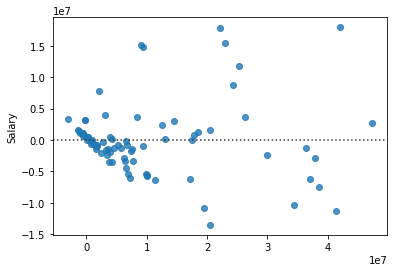

In [12]:
sns.residplot(x=predicted,y=y)

In [13]:
diff = np.array(predicted-y)

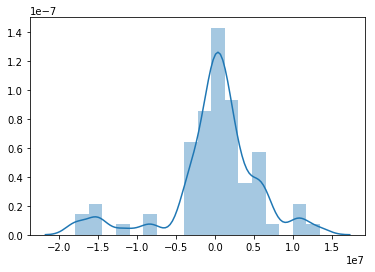

In [14]:
sns.distplot(diff)

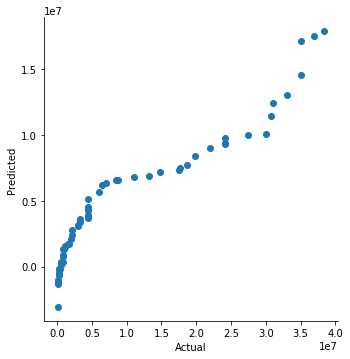

In [29]:
results = pd.DataFrame()
results["Predicted"] = predicted
results["Actual"] = y

ax = sqp.qqplot(y="Predicted", x="Actual", data=results, height=5)
plt.show()